In [1]:
import numpy as np
import matplotlib.pyplot as plt

import string
import random
import re
import requests
import os
import textwrap

In [2]:
### create substitution cipher

# one will act as the key, other as the value
letters1 = list(string.ascii_lowercase)
letters2 = list(string.ascii_lowercase)

true_mapping = {}

# shuffle second set of letters
random.shuffle(letters2)

# populate map
for k, v in zip(letters1, letters2):
  true_mapping[k] = v

In [3]:
### the language model

# initialize Markov matrix
M = np.ones((26, 26))

# initial state distribution
pi = np.zeros(26)

# a function to update the Markov matrix
def update_transition(ch1, ch2):
  # ord('a') = 97, ord('b') = 98, ...
  i = ord(ch1) - 97
  j = ord(ch2) - 97
  M[i,j] += 1

# a function to update the initial state distribution
def update_pi(ch):
  i = ord(ch) - 97
  pi[i] += 1

# get the log-probability of a word / token
def get_word_prob(word):
  # print("word:", word)
  i = ord(word[0]) - 97
  logp = np.log(pi[i])

  for ch in word[1:]:
    j = ord(ch) - 97
    logp += np.log(M[i, j]) # update prob
    i = j # update j

  return logp

# get the probability of a sequence of words
def get_sequence_prob(words):
  # if input is a string, split into an array of tokens
  if type(words) == str:
    words = words.split()

  logp = 0
  for word in words:
    logp += get_word_prob(word)
  return logp

In [4]:
### create a markov model based on an English dataset
# is an edit of https://www.gutenberg.org/ebooks/2701
# (I removed the front and back matter)


if not os.path.exists('moby_dick.txt'):
  print("Downloading moby dick...")
  r = requests.get('moby_dick.txt')
  with open('moby_dick.txt', 'w') as f:
    f.write(r.content.decode())

In [5]:
# for replacing non-alpha characters
regex = re.compile('[^a-zA-Z]')

# load in words
for line in open('moby_dick.txt'):
  line = line.rstrip()

  # there are blank lines in the file
  if line:
    line = regex.sub(' ', line) # replace all non-alpha characters with space

    # split the tokens in the line and lowercase
    tokens = line.lower().split()

    for token in tokens:
      # update the model

      # first letter
      ch0 = token[0]
      update_pi(ch0)

      # other letters
      for ch1 in token[1:]:
        update_transition(ch0, ch1)
        ch0 = ch1

# normalize the probabilities
pi /= pi.sum()
M /= M.sum(axis=1, keepdims=True)

In [6]:
### encode a message

# this is a random excerpt from Project Gutenberg's
# The Adventures of Sherlock Holmes, by Arthur Conan Doyle
# https://www.gutenberg.org/ebooks/1661

original_message = '''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.
'''

# Away they went, and I was just wondering whether I should not do well
# to follow them when up the lane came a neat little landau, the coachman
# with his coat only half-buttoned, and his tie under his ear, while all
# the tags of his harness were sticking out of the buckles. It hadn't
# pulled up before she shot out of the hall door and into it. I only
# caught a glimpse of her at the moment, but she was a lovely woman, with
# a face that a man might die for.

# My cabby drove fast. I don't think I ever drove faster, but the others
# were there before us. The cab and the landau with their steaming horses
# were in front of the door when I arrived. I paid the man and hurried
# into the church. There was not a soul there save the two whom I had
# followed and a surpliced clergyman, who seemed to be expostulating with
# them. They were all three standing in a knot in front of the altar. I
# lounged up the side aisle like any other idler who has dropped into a
# church. Suddenly, to my surprise, the three at the altar faced round to
# me, and Godfrey Norton came running as hard as he could towards me.

In [7]:
# a function to encode a message
def encode_message(msg):
  # downcase
  msg = msg.lower()

  # replace non-alpha characters
  msg = regex.sub(' ', msg)

  # make the encoded message
  coded_msg = []
  for ch in msg:
    coded_ch = ch # could just be a space
    if ch in true_mapping:
      coded_ch = true_mapping[ch]
    coded_msg.append(coded_ch)

  return ''.join(coded_msg)


encoded_message = encode_message(original_message)


# a function to decode a message
def decode_message(msg, word_map):
  decoded_msg = []
  for ch in msg:
    decoded_ch = ch # could just be a space
    if ch in word_map:
      decoded_ch = word_map[ch]
    decoded_msg.append(decoded_ch)

  return ''.join(decoded_msg)

In [8]:
### run an evolutionary algorithm to decode the message

# this is our initialization point
dna_pool = []
for _ in range(20):
  dna = list(string.ascii_lowercase)
  random.shuffle(dna)
  dna_pool.append(dna)

In [9]:
def evolve_offspring(dna_pool, n_children):
  # make n_children per offspring
  offspring = []

  for dna in dna_pool:
    for _ in range(n_children):
      copy = dna.copy()
      j = np.random.randint(len(copy))
      k = np.random.randint(len(copy))

      # switch
      tmp = copy[j]
      copy[j] = copy[k]
      copy[k] = tmp
      offspring.append(copy)

  return offspring + dna_pool

In [10]:
num_iters = 1000
scores = np.zeros(num_iters)
best_dna = None
best_map = None
best_score = float('-inf')
for i in range(num_iters):
  if i > 0:
    # get offspring from the current dna pool
    dna_pool = evolve_offspring(dna_pool, 3)

  # calculate score for each dna
  dna2score = {}
  for dna in dna_pool:
    # populate map
    current_map = {}
    for k, v in zip(letters1, dna):
      current_map[k] = v

    decoded_message = decode_message(encoded_message, current_map)
    score = get_sequence_prob(decoded_message)

    # store it
    # needs to be a string to be a dict key
    dna2score[''.join(dna)] = score

    # record the best so far
    if score > best_score:
      best_dna = dna
      best_map = current_map
      best_score = score

  # average score for this generation
  scores[i] = np.mean(list(dna2score.values()))

  # keep the best 5 dna
  # also turn them back into list of single chars
  sorted_dna = sorted(dna2score.items(), key=lambda x: x[1], reverse=True)
  dna_pool = [list(k) for k, v in sorted_dna[:5]]

  if i % 200 == 0:
    print("iter:", i, "score:", scores[i], "best so far:", best_score)

iter: 0 score: -2087.5673575935366 best so far: -1828.9205434170904
iter: 200 score: -1230.9532127595662 best so far: -1188.721051468202
iter: 400 score: -1259.132499121368 best so far: -1184.3546554833292
iter: 600 score: -1259.0619075158716 best so far: -1184.3546554833292
iter: 800 score: -1253.5344946248636 best so far: -1184.3546554833292


In [11]:
# use best score
decoded_message = decode_message(encoded_message, best_map)

print("LL of decoded message:", get_sequence_prob(decoded_message))
print("LL of true message:", get_sequence_prob(regex.sub(' ', original_message.lower())))


# which letters are wrong?
for true, v in true_mapping.items():
  pred = best_map[v]
  if true != pred:
    print("true: %s, pred: %s" % (true, pred))

LL of decoded message: -1184.3546554833292
LL of true message: -933.0312453751817
true: a, pred: s
true: b, pred: d
true: c, pred: g
true: d, pred: c
true: e, pred: r
true: f, pred: m
true: g, pred: p
true: h, pred: e
true: i, pred: l
true: j, pred: q
true: k, pred: x
true: l, pred: o
true: m, pred: b
true: n, pred: i
true: o, pred: a
true: p, pred: f
true: q, pred: j
true: r, pred: u
true: s, pred: t
true: t, pred: h
true: u, pred: n
true: w, pred: y
true: x, pred: k
true: y, pred: w


In [12]:
# print the final decoded message
print("Decoded message:\n", textwrap.fill(decoded_message))

print("\nTrue message:\n", original_message)

Decoded message:
 l heri oaniprc cayi her thurrh sic manic  st l rkfrghrc  hesh herur
yst s bryt li s osir yelge unit cayi dw air ysoo am her psucri  l orih
her athorut s esic li unddlip cayi herlu eautrt  sic urgrlvrc li
rkgesipr hyafrigr  s postt am esom sic esom  hya mloot am tesp hadsgga
sic st bnge limaubshlai st l ganoc crtlur sdanh bltt scoru  ha tsw
iahelip am esom s cazri aheru frafor li her irlpedanueaac li yeab l
yst iah li her orsth lihrurthrc  dnh yeatr dlapusfelrt l yst gabfroorc
ha olthri ha

True message:
 I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was 

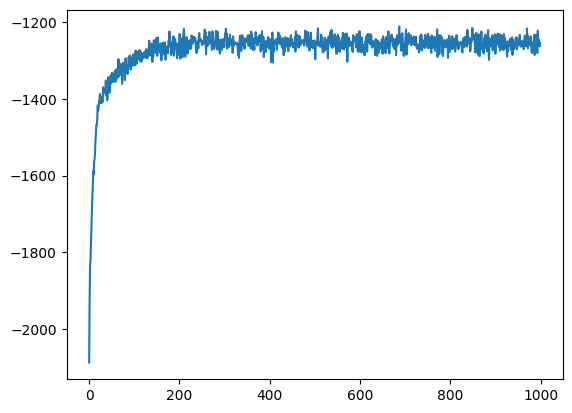

In [13]:
plt.plot(scores)
plt.show()